### Retrieve historical and projected tasmin from NEX-GDDP-CMIP6 for existing orchards.

using 10 years of data to start out

In [42]:
import sys 
import os
import s3fs

rel_path = "../src"
directory_path = os.path.abspath(os.path.join(os.getcwd(), rel_path))
sys.path.append(directory_path)

from nex_gddp_cmip6 import get_nex_dataset, TIME_OPTIMIZED_SCENARIOS, AVAILABLE_VARIABLES, load_region, select_region

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import dask
from dask.distributed import Client

In [11]:
# Load Data

ds_historical = get_nex_dataset(AVAILABLE_VARIABLES,["historical"])
#ds_projection = get_nex_dataset(AVAILABLE_VARIABLES,["projection"])

In [12]:
geodf = load_region('../assets/data/external/MI_avas.geojson')
ds_historical_clipped = select_region(ds_historical, geodf)
#ds_projection_clipped = select_region(ds_projection, geodf)

In [13]:
ds_historical_clipped 

<xarray.Dataset>
Dimensions:      (lat: 16, lon: 14, model: 20, scenario: 1, time: 23741)
Coordinates:
  * lat          (lat) float64 41.88 42.12 42.38 42.62 ... 45.12 45.38 45.62
  * lon          (lon) float64 93.38 93.62 93.88 94.12 ... 96.12 96.38 96.62
  * model        (model) <U10 'ACCESS-CM2' 'ACCESS-ESM' ... 'UKESM1-0-L'
  * scenario     (scenario) <U10 'historical'
  * time         (time) datetime64[ns] 1950-01-01T12:00:00 ... 2014-12-31T12:...
    spatial_ref  int32 0
Data variables:
    hurs         (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
    huss         (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
    pr           (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
    rlds         (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
    rsds         (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
    sfcWind      (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
    tas          (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
    tasmax       (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
    tasmin       (model, scenario, time, lat, lon) float32 dask.array<chunksize=(20, 1, 23741, 13, 2), meta=np.ndarray>
Attributes: (12/22)
    Conventions:           CF-1.7
    activity:              NEX-GDDP-CMIP6
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY 4.0
    cmip6_source_id:       ACCESS-CM2
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    scenario:              historical
    source:                BCSD
    title:                 ACCESS-CM2, r1i1p1f1, historical, global downscale...
    tracking_id:           f9f489de-f5f7-43de-8f55-f0c001fad19a
    variant_label:         r1i1p1f1
    version:               1.1

In [14]:
# sample vis ~ estimated 2 minutes of runtime.
ds_historical['tasmin'].isel(model = 0, time=0).plot()


Retrieve historical and projected tasmin from NEX-GDDP-CMIP6 for existing orchards. 

In [15]:
# using one climate model, between a very short time range of 10 years
da = ds_historical_clipped['tasmin'].sel(model = 'ACCESS-CM2', time=slice('1950-01-01T12:00:00.000000000', '1960-12-31T12:00:00.000000000'))

In [16]:
da

<xarray.DataArray 'tasmin' (scenario: 1, time: 4018, lat: 16, lon: 14)>
dask.array<getitem, shape=(1, 4018, 16, 14), dtype=float32, chunksize=(1, 4018, 13, 12), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 41.88 42.12 42.38 42.62 ... 45.12 45.38 45.62
  * lon          (lon) float64 93.38 93.62 93.88 94.12 ... 96.12 96.38 96.62
    model        <U10 'ACCESS-CM2'
  * scenario     (scenario) <U10 'historical'
  * time         (time) datetime64[ns] 1950-01-01T12:00:00 ... 1960-12-31T12:...
    spatial_ref  int32 0
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: minimum
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Minimum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

In [ ]:
# Initiate Dask Cluster

endpoint = ""

if endpoint:
    client = Client(endpoint)

else:
    client = Client()

client

In [ ]:
# when ready to shutdown cluster
#client.shutdown()

# Pandas

convert to pandas dataframe
- https://docs.xarray.dev/en/latest/generated/xarray.DataArray.to_dataframe.html

Notes: 
- I noticed that when a dask client is running, that parallel computing is performed for the operation.
- might get issues with deserializing, so need to upgrade msgpack to latest version
    - https://github.com/dask/distributed/issues/8038

In [17]:
# with dask client runs for about 1:32 minutes
# shape of (900032, 3), for 10 years worth of data on the subset
pd_df = da.to_dataframe(name = 'tsmin_df') 

print(pd_df.shape)

In [26]:
pd_df.dropna(inplace = True)
pd_df = pd_df.reset_index('time')
pd_df.head()

time       model  spatial_ref  \
scenario   lat    lon                                                   
historical 41.875 93.375 1950-01-01 12:00:00  ACCESS-CM2            0   
                  93.625 1950-01-01 12:00:00  ACCESS-CM2            0   
                  93.875 1950-01-01 12:00:00  ACCESS-CM2            0   
           42.125 93.625 1950-01-01 12:00:00  ACCESS-CM2            0   
                  93.875 1950-01-01 12:00:00  ACCESS-CM2            0   

                            tsmin_df  
scenario   lat    lon                 
historical 41.875 93.375  258.037994  
                  93.625  257.776245  
                  93.875  257.361115  
           42.125 93.625  258.672577  
                  93.875  258.194580

In [39]:
# runs fast locally
pd_df_gb = pd_df.groupby(pd_df['time'].dt.year)['tsmin_df'].mean()

Text(0.5, 1.0, 'ACCESS-CM2 - tsmin_df ')

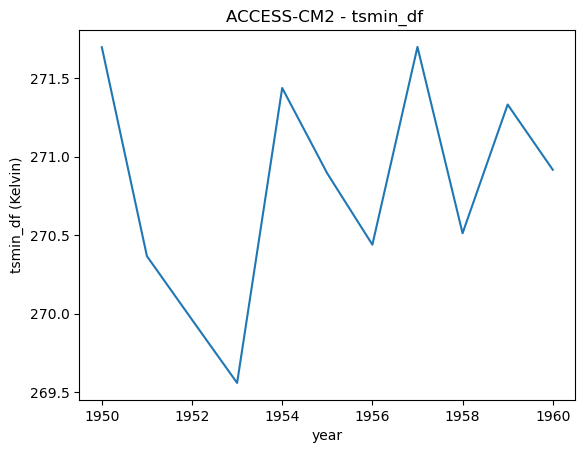

In [44]:
plt.plot(pd_df_gb)
plt.xlabel('year')
plt.ylabel('tsmin_df (Kelvin)')
plt.title('ACCESS-CM2 - tsmin_df ')

## Dask Dataframe

under the hood is a pandas dataframe

In [35]:
# https://docs.xarray.dev/en/latest/generated/xarray.DataArray.to_dask_dataframe.html

dask_df = da.to_dask_dataframe(['lat','lon','scenario','time'])

In [36]:
# lazy loading, pre-compute:
dask_df

,lat,lon,scenario,time,model,spatial_ref,tasmin
npartitions=4,,,,,,,
0,float64,float64,object,datetime64[ns],object,int32,float32
337512,...,...,...,...,...,...,...
731276,...,...,...,...,...,...,...
787528,...,...,...,...,...,...,...
900031,...,...,...,...,...,...,...


In [37]:
# Takes about 1 minutes to complete
dask_df = dask_df.compute()

In [47]:
# size compares to pandas
print(dask_df.shape)

(96432, 7)


In [46]:
dask_df = dask_df.dropna()
print(dask_df.shape)

In [48]:
dask_df.head(5)

,lat,lon,scenario,time,model,spatial_ref,tasmin
0,41.875,93.375,historical,1950-01-01 12:00:00,ACCESS-CM2,0,258.037994
1,41.875,93.375,historical,1950-01-02 12:00:00,ACCESS-CM2,0,259.913177
2,41.875,93.375,historical,1950-01-03 12:00:00,ACCESS-CM2,0,257.775818
3,41.875,93.375,historical,1950-01-04 12:00:00,ACCESS-CM2,0,256.759705
4,41.875,93.375,historical,1950-01-05 12:00:00,ACCESS-CM2,0,255.912247


0         1950
1         1950
2         1950
3         1950
4         1950
          ... 
883955    1960
883956    1960
883957    1960
883958    1960
883959    1960
Name: time, Length: 96432, dtype: int32

In [51]:
# Perform Groupby
# https://examples.dask.org/dataframes/02-groupby.html

dask_df_gb = dask_df.groupby(dask_df['time'].dt.year)['tasmin'].mean()

In [52]:
dask_df_gb 

time
1950    271.698486
1951    270.366425
1952    269.961060
1953    269.558136
1954    271.438751
1955    270.893768
1956    270.439606
1957    271.700500
1958    270.512482
1959    271.333191
1960    270.917450
Name: tasmin, dtype: float32

Text(0.5, 1.0, 'ACCESS-CM2 - tsmin_df ')

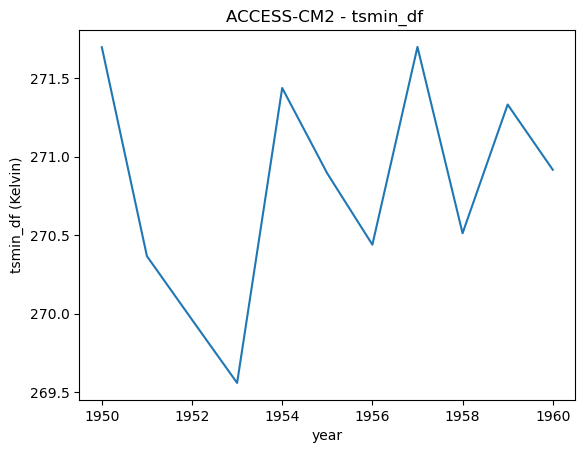

In [53]:
plt.plot(dask_df_gb)
plt.xlabel('year')
plt.ylabel('tsmin_df (Kelvin)')
plt.title('ACCESS-CM2 - tsmin_df ')